In [6]:
import collections
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.contrib import seq2seq
import time

In [7]:
poetry_file ='poetry.txt'

## Data Preprocessing

In [8]:
import re
import string
from collections import Counter

In [9]:
class readPoems:
    '''
    Read Chinese poems and generate poem vectors for training
    Args:
    file_path:file path of Chinese poems
    '''
    def __init__(self, file_path):
        self.file_path = file_path
        self.poems = self._readfile()
        
    
    
    def _preProcessor(self, s):
        #remove letters
        s = re.sub('[a-zA-Z一《》]', '', s)
        #remove blanks
        s = re.sub(' ', '', s)
        #remove digits
        s = re.sub('['+string.digits+']', '', s)
        #remove line ends
        s = re.sub('\n', ' ', s)
        s = s.rstrip()
        return s
    
    def _readfile(self):
        poems = []
        with open(self.file_path, "r", encoding='utf-8',) as fi:
            for line in fi:
                content = line.strip().split(':')[1]
                if len(content) > 10:#skip short sentences
                    poem = self._preProcessor(content)
                    #Set beginning and ending for each poem
                    poem ='(' + poem +')'
                    poems.append(poem)
                    
        #Sort the poems according to their lengths
        poems_lens = [len(poem) for poem in poems]
        poem_tuple = list(zip(poems_lens, poems))
        poem_tuple.sort()
        poems = [item[1] for item in poem_tuple]
        return poems
    
    def _poem2chars(self):
        #Split each poem into Chinese characters
        poems_chars= []
        all_chars = []
        for poem in self.poems:
           #Skip too long or too short sentences
           if len(poem) > 80 or len(poem)<5:
              continue
           if poem != ' ' or poem != None:
              #Turn each poem into a list of vectors
              poems_chars.append([char for char in poem])
              #Collect all the chars
              all_chars.extend([char for char in poem])
        return poems_chars, all_chars
    
    def buildVocab(self):
        _, all_chars = self._poem2chars()
        #Calculate frequencies of each character
        chars_freq = Counter(all_chars)
        #Filter out those low frequency characters
        vocab = [u for u,v in chars_freq.items() if v>10]
        if ' ' not in vocab:
            vocab.append(' ')
        #Map each char into an ID
        char_id_map = dict(zip(vocab, range(len(vocab))))
        #Map each ID into a word
        id_char_map = dict([(value, key) for key, value in char_id_map.items()])
        return vocab, char_id_map, id_char_map
    
    def poem2vecs(self):
        #Map each word into an ID
        poems_chars, _ = self._poem2chars()
        vocab, char_id_map, id_char_map = self.buildVocab()
        def char2id(c):
            try:
               ID = char_id_map[c]
            except:#Trun those less frequent words into blanks
               ID = char_id_map[' ']
            return ID
        #Turn each poem into a list of word Ids
        chars_vecs = lambda chars: [char2id(char) for char in chars]
        poems_vecs = [chars_vecs(chars) for chars in poems_chars]
        return poems_vecs

In [10]:
poem_model = readPoems(poetry_file)
vocab, char_id_map, id_char_map = poem_model.buildVocab()
poems_vecs = poem_model.poem2vecs()

In [11]:
poems_vecs[:10]

[[429, 1895, 2840, 1634, 1932, 764, 3647, 1915, 239, 1075, 100, 2831, 1380],
 [429, 1895, 1292, 2062, 3237, 3239, 764, 1807, 3352, 688, 775, 2831, 1380],
 [429, 1895, 2872, 2232, 1863, 3685, 764, 328, 1873, 3404, 2536, 2831, 1380],
 [429, 3061, 726, 3580, 985, 2035, 764, 54, 3188, 817, 2142, 2831, 1380],
 [429, 570, 688, 1520, 2937, 764, 3036, 1815, 405, 1793, 507, 2831, 1380],
 [429, 1964, 2826, 570, 1709, 1178, 764, 38, 2872, 23, 305, 2831, 1380],
 [429, 2848, 643, 1090, 315, 764, 2457, 2771, 661, 1482, 3422, 2831, 1380],
 [429, 726, 1025, 50, 83, 1880, 764, 3122, 2061, 3690, 2395, 2831, 1380],
 [429, 3181, 139, 2271, 2171, 2171, 764, 570, 2009, 1321, 2997, 2831, 1380],
 [429, 3181, 139, 2271, 2171, 2171, 764, 570, 2009, 1321, 2997, 2831, 1380]]

In [12]:
poem_model.poems[:10]

['(万木无叶，客心悲此时。)',
 '(万般思后行，失废前功。)',
 '(万里岐路多，身天地窄。)',
 '(九子不葬父，女打荆棺。)',
 '(双前进士，两个阿孩儿。)',
 '(吟中双鬓白，笑里生贫。)',
 '(如蒙被服，方堪称福田。)',
 '(子母相去离，连台拗倒。)',
 '(宝帐香重重，双红芙蓉。)',
 '(宝帐香重重，双红芙蓉。)']

In [13]:
def char2id(c):
    try:
        ID = char_id_map[c]
    except:#Trun those less frequent words into blanks
        ID = char_id_map[' ']
    return ID
      
#turn an ID into a character
def id2char(ID):
    try:
        char = id_char_map[ID]
    except:
        char = ' '
    return char

In [14]:
print('唐诗数量:', len(poems_vecs))

唐诗数量: 34921


In [15]:
len(vocab)

3691

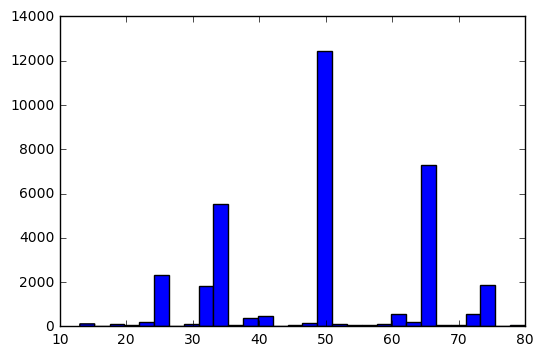

In [16]:
from matplotlib import pyplot as plt
poems_lens = [len(chars) for chars in poems_vecs]
plt.hist(poems_lens, bins=30)
plt.show()

In [17]:
print('Min length:', np.amin(poems_lens))
print('Max length:', np.amax(poems_lens))
print('Average length:', np.mean(poems_lens))
print('Median length:', np.median(poems_lens))

Min length: 13
Max length: 80
Average length: 49.4196615217
Median length: 50.0


In [18]:
np.percentile(poems_lens, [0, 25, 50, 75, 95])

array([ 13.,  34.,  50.,  65.,  74.])

**It seems more than 95% peoms has a length less than 167 characters.**

In [19]:
char2id(' ')

3690

## Input Data Generation

In [20]:
class generateSamples:
    '''Generate samples for training'''
    
    def __init__(self, batch_size, poems_vecs):
        '''Pass batch size and poems vectors'''
        self.index = 0
        self.batch_size = batch_size
        self.poems_vecs = poems_vecs
        self.poem_count = len(poems_vecs)
        self.max_len = max(map(len, poems_vecs))
        
    def generate_batch(self, same_length=False):
        '''Generate a training sample each time'''
        start = self.index
        end = start + self.batch_size
        #In case end goes beyong the range of the samples
        if end > self.poem_count:
            self.index = 0
            start = 0
            end = self.batch_size
        data = self.poems_vecs[start: end]
        #Set the max lengths as the size of the input
        if same_length:
            max_len = self.max_len
        else:
            max_len = max(map(len, data))
        #Record lengths for each poem
        lengths = [len(item) for item in data]
        lengths = np.array(lengths)
        self.index = (self.index + self.batch_size)%self.poem_count
        #Create input and label
        x = np.full((self.batch_size,max_len), char2id(' '), np.int32)
        y = np.copy(x)
        for i in range(self.batch_size):
            #the first n elements as input
            x[i, :(len(data[i])-1)] = data[i][:-1]
            #the last n elements as labels
            y[i, :(len(data[i])-1)] = data[i][1:]
        return x, y, lengths, max_len

In [21]:
#Generate series of inputs and labels
#Batch_size * lengths
generatesamples = generateSamples(64, poems_vecs)
x, y, lengths, _ = generatesamples.generate_batch()

In [22]:
max_poem_len = generatesamples.max_len
max_poem_len

80

## RNN Model

In [23]:
class config:
    vocab_size = len(vocab)
    embed_size = 128
    batch_size = 64
    layer_size = 2
    max_poem_len = max_poem_len

In [24]:
chunk_num = int(len(poems_vecs)/config.batch_size)
chunk_num

545

In [25]:
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('placeholder'):
        input_data = tf.placeholder(tf.int32, [config.batch_size, None])
        output_targets = tf.placeholder(tf.int32, [config.batch_size, None])
        lens = tf.placeholder(tf.int32, [config.batch_size])
        #keep_prob_input = tf.placeholder(tf.float32)
        #keep_prob_cell = tf.placeholder(tf.float32)
    with tf.name_scope('Embedding'):
        #Create embeddings for the characters
        embeddings = tf.Variable(tf.random_uniform([config.vocab_size, 
                                                    config.embed_size], -1.0, 1.0))
        inputs = tf.nn.embedding_lookup(embeddings, input_data)
        #Dropout
        #inputs = tf.nn.dropout(inputs, keep_prob=0.7)

    with tf.name_scope('RNNLayer') as scope:
        #gru_cell = rnn.GRUCell(config.embed_size）
        def lstm():
            return rnn.BasicLSTMCell(config.embed_size, forget_bias=0.0, 
                                      state_is_tuple=True, reuse=tf.get_variable_scope().reuse) 
        lstm_cell = lstm
        cell = rnn.MultiRNNCell([lstm_cell() for _ in range(config.layer_size)], 
                                state_is_tuple=True)
        initial_state = cell.zero_state(config.batch_size, tf.float32)
        #Dropout
        #cell = rnn.DropoutWrapper(lstm_cell, output_keep_prob=0.7)
        weights = tf.Variable(tf.random_normal([config.embed_size, config.vocab_size]), name='weight')
        biases = tf.Variable(tf.random_normal([config.vocab_size]), name='bias')
        #outputs, status = rnn.static_rnn(lstm, inputs, sequence_length=lens)
        #Dynamic RNN with given lengths for each poem
        #status = initial_state
        inputs = tf.nn.dropout(inputs, 0.8)
        outputs, status = tf.nn.dynamic_rnn(cell, inputs, initial_state=initial_state,
                                            sequence_length=lens, dtype=tf.float32, 
                                            scope='RNNLayer')
        output = tf.reshape(outputs,[-1, config.embed_size])
        logits = tf.matmul(output, weights) + biases
        #logits = tf.contrib.layers.fully_connected(output, config.vocab_size, activation_fn=None)
        probs = tf.nn.softmax(logits)
        

    with tf.name_scope('Optimizer'):
        targets = tf.reshape(output_targets, [-1])
        loss = tf.contrib.legacy_seq2seq.sequence_loss_by_example(
            [logits],
            [targets],
            [tf.ones_like(targets, dtype=tf.float32)], config.vocab_size)
        cost = tf.reduce_mean(loss) 
        learning_rate = tf.Variable(0.0, trainable=False)
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars), 5)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        train_op = optimizer.apply_gradients(zip(grads, tvars))

    
    with tf.name_scope('Validation'):
        tf.get_variable_scope().reuse_variables()
        #Define initial state for validation set
        initial_sample_state = cell.zero_state(1, tf.float32)
        sample_input = tf.placeholder(tf.int32, shape=[1, 1])
        sample_emd = tf.nn.embedding_lookup(embeddings, sample_input)
        state_sample = initial_sample_state
        output_sample, status_sample = tf.nn.dynamic_rnn(cell, sample_emd, initial_state=state_sample,
                                             dtype=tf.float32, scope='RNNLayer')
        output_sample = tf.reshape(output_sample,[-1, config.embed_size])
        logits_sample = tf.matmul(output_sample, weights) + biases
        #logits_sample = tf.contrib.layers.fully_connected(output_sample, config.vocab_size, activation_fn=None)
        probs_sample= tf.nn.softmax(logits_sample)
        prediction = tf.argmax(probs_sample, 1)

In [ ]:
epochs = 20
with tf.Session(graph=graph) as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for l in range(epochs):
        for i in range(chunk_num):
            sess.run(tf.assign(learning_rate, 0.003*((0.98)**l)))
            x, y, lengths, _ = generatesamples.generate_batch()
            feed_dict = {input_data:x, output_targets:y, lens:lengths}
            l, _, _ = sess.run([cost, status, train_op], feed_dict=feed_dict)
            if i%100 == 0:
                print('Loss:', round(l, 4))
            if i % 200 == 0:
                print('=' * 80)
                feed = np.zeros([1, 1])
                feed[0, 0] = char2id('(')
                s = id2char(feed[0][0])
                #Initialize the original state
                state_ = sess.run(initial_sample_state)
                [pred_id, state_] = sess.run([prediction, status_sample], feed_dict={sample_input: feed, 
                                                                          state_sample: state_})
                #Make current prediction as next input
                #Use current state as next initialstate
                for _ in range(50):
                    s += id2char(pred_id[0])
                    #Set '(' as beginning and ')' as ending
                    if id2char(pred_id[0]) == ')':
                        break
                    feed[0, 0] = pred_id[0]
                    [pred_id, state_] = sess.run([prediction, status_sample], 
                                                 feed_dict={sample_input: feed, 
                                                            state_sample: state_})
                print(s)
                print('='*80)

Loss: 8.5702
(仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇仇
Loss: 6.1437
Loss: 6.8374
(不知不知不知年。)
Loss: 5.6801
Loss: 5.9747
(不知不知何处处，不知何处不知人。)
Loss: 5.5316
Loss: 5.2316
(春风不可见，春风落日来。)
Loss: 5.7196
Loss: 6.5121
(不知何处不知。)
Loss: 5.2609
Loss: 5.475
(不知春水不知春，不知春水不堪情。不知不得无人事，不知何处不知人。)
Loss: 5.1457
Loss: 4.8361
(春风吹落叶，寒风落日开。水流秋色满，山色不相逢。)
Loss: 5.2803
Loss: 6.0457
(江南山下水流流，不见三年不得知。不知此地无人事，不是人间不可怜。不知此地无人事，不是人间不可怜。)
Loss: 4.9414
Loss: 5.2007
(    不得归，不知何处是何人。今朝不得无人事，不见春风不可怜。)
Loss: 4.887
Loss: 4.6127
(春风吹落叶，春色满山阴。水色无人事，春风满地深。不知春草色，不是故人同。)
Loss: 5.0337
Loss: 5.8426
(白发无人不可知，不知何处是谁家。山中不见人间事，不是人间不可知。不是不知何处去，不知何处是谁家。)
Loss: 4.7752
Loss: 5.0283
(白发无人不得归，不知何处是无人。)
Loss: 4.7709
Loss: 4.504
(春风吹落叶，春色满庭枝。日暮江南树，春风满地深。春风吹落日，春色满庭枝。)
Loss: 4.884
Loss: 5.6557
(白云何处是谁家，白发何人更有情。不是不知何处去，不知何处是谁家。山川不见春风起，月照江湖水色长。不是
Loss: 4.6777
Loss: 4.9281
(白云何处不堪闻，白发无人不见人。)
Loss: 4.6811
Loss: 4.4289
(春风吹落日，春色满山阴。水色无人语，山川日日斜。春风吹落日，春色满山阴。不是长安路，无人不可知。)
Loss: 4.7683
Loss: 5.4578
(白云何处是谁家，白发无人不可知。山水不知何处去，山川不见水流流。风吹不似江山月，月照江湖水绕天。莫

## RNN Model Object

In [20]:
import functools

def lazy_property(function):
    attribute = '_cache_' + function.__name__

    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)

    return decorator

In [21]:
class testConfig:
    vocab_size = len(vocab)
    embed_size = 128
    batch_size = 1
    layer_size = 2
    max_poem_len = max_poem_len

Note, in order to share parameters such as weights and biases in the architecture, it is necessary to specify "variable_scope" and use "tf.get_variable" method to share.

In [22]:
#Define a RNN model 
class rnnModel:
    '''Define a basic model for character classification, the model
    Provides graph structure of tensorflow'''
    
    def __init__(self, x, y, lengths, config, is_training=True):
        self.x = x
        self.y = y
        self.lengths = lengths
        self.is_training = is_training
        self.batch_size = config.batch_size
        self.vocab_size = config.vocab_size
        self.embed_size = config.embed_size
        self._learning_rate = None
        self._initial_state = None
        self._final_state = None
        self.prediction
        if not is_training:
            print('Initializing Testing Model！')
            return
        self.cost
        self.optimize
        print('Initializing Training Model!') 
    
    @lazy_property
    def cost(self):
        #定义权重和偏置参数变量
        logits= self.rnnLayer
        targets = tf.reshape(self.y, [-1])
        loss = tf.contrib.legacy_seq2seq.sequence_loss_by_example(
            [logits],
            [targets],
            [tf.ones_like(targets, dtype=tf.float32)])
        cost = tf.reduce_mean(loss) 
        return cost

    @lazy_property
    def optimize(self):
        cost = self.cost
        #with tf.name_scope('Optimizer'):
        self._learning_rate = tf.Variable(0.0, trainable=False)
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars), 5)
        optimizer = tf.train.AdamOptimizer(self._learning_rate)
        train_op = optimizer.apply_gradients(zip(grads, tvars))
        return train_op

    @lazy_property
    def prediction(self):
        logits= self.rnnLayer
        probs = tf.nn.softmax(logits)
        prediction = tf.argmax(probs, 1)
        return prediction
    
    @lazy_property
    def rnnLayer(self):
        #Create two layers rnn
        def lstm():
            return rnn.BasicLSTMCell(self.embed_size, forget_bias=0.0, 
                                      state_is_tuple=True, reuse=tf.get_variable_scope().reuse) 
        lstm_cell = lstm
        #if self.is_training:
           #def lstm_cell():
                #return tf.contrib.rnn.DropoutWrapper(lstm(), output_keep_prob=0.8)
        cell = rnn.MultiRNNCell([lstm_cell() for _ in range(2)], 
                                    state_is_tuple=True)
            
        self._initial_state = cell.zero_state(self.batch_size, tf.float32)
        #Note we need get_variable method to share weights between objects
        with tf.device("/cpu:0"):
            embeddings = tf.get_variable('embedding', [self.vocab_size,  self.embed_size])
            inputs = tf.nn.embedding_lookup(embeddings, self.x)
        lens = tf.constant(np.ones(1))
        #if self.is_training:
            #inputs = tf.nn.dropout(inputs, 0.6)
            #lens = self.lengths
        state = self._initial_state
        with tf.variable_scope('RNN'):
            outputs, final_state = tf.nn.dynamic_rnn(cell, inputs, 
                                                 initial_state=state,
                                                #sequence_length=lens,
                                                 dtype=tf.float32, scope='RNN')
        self._final_state = final_state
        output = tf.reshape(outputs,[-1, self.embed_size])
        #self.weights = weights = tf.Variable(tf.random_normal([self.embed_size, config.vocab_size]), name='weight')
        #biases = tf.Variable(tf.random_normal([self.vocab_size]), name='bias')
        weights = tf.get_variable('weights', [self.embed_size, config.vocab_size], dtype=tf.float32)
        biases = tf.get_variable('biases', [config.vocab_size], dtype=tf.float32)
        logits = tf.matmul(output, weights) + biases
        #logits = tf.contrib.layers.fully_connected(output, self.vocab_size, activation_fn=None)
        return logits
    
    @property
    def learningRate(self):
        return self._learning_rate
    
    @property
    def initialState(self):
        return self._initial_state
    
    @property
    def finalState(self):
        return self._final_state

In [23]:
graph3 = tf.Graph()
with graph3.as_default():
    initializer = tf.random_uniform_initializer(-0.2, 0.2)
    with tf.name_scope('Train'):
        input_data = tf.placeholder(tf.int32, [config.batch_size, None])
        output_targets = tf.placeholder(tf.int32, [config.batch_size, None])
        lens = tf.placeholder(tf.int32, [config.batch_size])
        with tf.variable_scope("Model", reuse=None,initializer=initializer):
            train_model = rnnModel(input_data, output_targets, lens, config)
            
    with tf.name_scope('Valid'):
        valid_data = tf.placeholder(tf.int32, [config.batch_size, None])
        valid_targets = tf.placeholder(tf.int32, [config.batch_size, None])
        valid_lens = tf.placeholder(tf.int32, [config.batch_size])
        with tf.variable_scope("Model", reuse=True):
            valid_model = rnnModel(valid_data, valid_targets, valid_lens, config, is_training=False)
            
    with tf.name_scope('Test'):
        sample_data = tf.placeholder(tf.int32, [1, 1])
        sample_len = tf.placeholder(tf.int32, [1])
        with tf.variable_scope("Model", reuse=True, initializer=initializer):
            test_model = rnnModel(x=sample_data, y=None, lengths=sample_len, config=testConfig, is_training=False)

Initializing Training Model!
Initializing Testing Model！
Initializing Testing Model！


In [ ]:
epochs = 20
states = []
with tf.Session(graph=graph3) as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for l in range(epochs):
        sess.run(tf.assign(train_model.learningRate, 0.004*(0.97**l)))
        for i in range(chunk_num):
            #Assign a learning rate
            #sess.run(tf.assign(model.isTraining, True))
            x, y, lengths, _ = generatesamples.generate_batch()
            feed_dict = {input_data:x, output_targets:y, lens:lengths}
            l, _ = sess.run([train_model.cost, train_model.optimize], feed_dict=feed_dict)
            if i%50 == 0:
                print('Loss:', round(l, 4))
            if i%200 == 0:

                feed = np.zeros([1, 1])
                feed[0, 0] = char2id('(')
                s = '('

                #Specify initial state
                #Initialize the state of testing data
                initial_state = sess.run(test_model.initialState)
                state = initial_state
                #Record current final state and make it as next inital state
                #s = id2char(pred_id[0][0])
                for _ in range(50):
                    fd= {sample_data:feed, test_model.initialState:state}
                    state, pred_id = sess.run([test_model.finalState, 
                                                     test_model.prediction], feed_dict=fd)
                    feed[0, 0] = pred_id[0]
                    s += id2char(pred_id[0])
                    if id2char(pred_id[0]) == ')':
                        break
                print(s)
                print('='*80)

    

Loss: 8.2395
(香荒愈愈愈夷俱恨恨汶罾罾等等劚慢慢铿铿镌臼奔奔敬镌鸥瞳瞳瞳寨请请请曜芙乖乖乖仪仪葭葭守守如螭等请请请
Loss: 6.0486
Loss: 5.576
Loss: 5.6784
Loss: 5.5052
(山山山，不人山人。)
Loss: 5.5468
Loss: 5.3934
Loss: 5.3163
Loss: 5.8321
(不知不有不得，不知不有不知。)
Loss: 5.5796
Loss: 5.3922
Loss: 5.0863
(春日   ，天人不可知。)
Loss: 5.5259
Loss: 4.9329
Loss: 5.1019
Loss: 5.0249
(山山日日，山山不可。不知何处，何事不相知。)
Loss: 5.1183
Loss: 4.9311
Loss: 4.8759
Loss: 5.429
(山上春风满，春风不见春。风风不见春，月下青云不可。不知不得人，不是人间不可知。)
Loss: 5.1764
Loss: 5.0716
Loss: 5.0369
(天里无人事，天中不可知。)
Loss: 5.1784
Loss: 4.6875
Loss: 4.8659
Loss: 4.7898
(山上无人，何人不可然。不知何处，何事是何人。不知何处，何事是何人。)
Loss: 4.9359
Loss: 4.7663
Loss: 4.714
Loss: 5.1986
(高台不得不知人，白首无人不可知。风吹不觉风花落，月上江山月满山。风吹水上风花落，月上山山月上春。不知
Loss: 4.9989
Loss: 4.9025
Loss: 4.8747
(     ，     。                                      
Loss: 4.9766
Loss: 4.5253
Loss: 4.701
Loss: 4.6209
(白发无穷事，无人不可然。不知何处，何事不知。不见山中去，何人不可知。)
Loss: 4.7903
Loss: 4.6236
Loss: 4.5688
Loss: 5.0236
(高台不得归人别，白发无人不得知。不知此地无人事，不得人间不得知。不知此地无人事，不得东山不得知。)
Loss: 4.8755
Loss: 4.7813
Loss: 4.7415
(白云生不得，不见此中同。日